In [ ]:
pwd

In [2]:
!date

Wed Sep 28 14:30:46 EDT 2022


#### BEGIN GPU CHECKS

In [3]:
import os
gpu_id = 3
os.environ['CUDA_VISIBLE_DEVICES']=str(gpu_id)

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187          20          98           4          68         161
Swap:            11           0          11


In [6]:
# CHECK GPU
import nvidia_smi
try:
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(gpu_id)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

    print("Total memory:", (info.total/1024/1024/1024))
    print("Free memory:", (info.free/1024/1024/1024))
    print("Used memory:", (info.used/1024/1024/1024))

    nvidia_smi.nvmlShutdown()
except:
    pass

Total memory: 15.78173828125
Free memory: 15.337890625
Used memory: 0.44384765625


In [7]:
# Run GPU test
import tensorflow as tf
import timeit,pickle

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
    with tf.device('/cpu:0'):
        random_image_cpu = tf.random.normal((100, 100, 100, 3))
        net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
    with tf.device('/device:GPU:0'):
        random_image_gpu = tf.random.normal((100, 100, 100, 3))
        net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.38800278026610613
GPU (s):
0.03198680281639099
GPU speedup over CPU: 12x


#### END GPU CHECKS

#### DATA SET UP

In [8]:
%%time

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP

import os
from datetime import datetime; now = datetime.now
tqdm = partial(tqdm, position=0, leave=True) 


from importlib import reload
import helper_funcs;reload(helper_funcs);from helper_funcs import *
del helper_funcs
import make_models;reload(make_models);from make_models import *
del make_models

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

import tensorflow as tf
reload(tf)

CPU times: user 8.87 s, sys: 469 ms, total: 9.34 s
Wall time: 10.7 s


<module 'tensorflow' from '/data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [9]:
analysis_name = 'test-7'

# NB name for copying
nb_name = '009-train-CVAE-cmats.ipynb'

# Hyperparameters
latent_dim1 = 16
latent_dim2 = 16
beta = 1e-6
gamma = 1
batch_size = 32
kernel_size = 3
filters = 8
intermediate_dim = 128
nlayers = 4
strides = 2
learning_rate=0.001
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')

In [10]:
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
print(analysis_name)

test-7


In [11]:
df = pd.read_csv('../Data/df_comb_S1558.csv')

unique_values = np.unique(df['dataset'].values)
new_vals = np.arange(1,len(unique_values)+1)
df['dataset_id'] = [new_vals[val==unique_values][0] for val in df['dataset'].values]
df

,Unnamed: 0,Unnamed: 0.1,subID,diag,DSMIV,age,gender,handedness_cat,handedness_score,fiq,...,srs_mannerisms,sqc_total,aq_total,comorbidity,bmi,vineland_sum,dataset,siteID,sub,dataset_id
0,2,2,50004,1,1.0,19.09,1,R,NaN,113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050004,1
1,8,8,50010,1,1.0,35.20,1,L,NaN,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050010,1
2,9,9,50011,1,1.0,16.93,1,L,NaN,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050011,1
3,10,10,50012,1,1.0,21.48,1,R,NaN,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050012,1
4,12,12,50014,1,1.0,14.20,1,R,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,2050,746,30163,2,NaN,8.00,2,1.0,81.25,136.0,...,2.0,1.0,NaN,none,NaN,NaN,ABIDE2,23,sub-30163,2
1554,2051,747,30164,2,NaN,10.00,2,1.0,100.00,115.0,...,4.0,2.0,NaN,none,NaN,NaN,ABIDE2,23,sub-30164,2
1555,2052,748,30165,2,NaN,12.00,2,1.0,100.00,120.0,...,0.0,NaN,NaN,none,NaN,NaN,ABIDE2,23,sub-30165,2
1556,2053,749,30166,2,NaN,10.00,2,1.0,100.00,112.0,...,6.0,4.0,NaN,tourettes/tics,NaN,NaN,ABIDE2,23,sub-30166,2


In [12]:
# cmats = np.load('../Data/cmats_r51_S1502.npz')['data']
# cmats.shape
cmats = np.load('../Data/cmats_S1558.npz')['cmats']
cmats = (cmats+1)/2
cmats.shape

(1558, 51, 51)

#### SET UP DATA LOADER AND MODEL

In [13]:
# data loader
class cvae_data_loader():
    ''' this is the info'''
    def __init__(self,cmats,df,batch_size=32):
        
        self.df = df
        self.cmats = cmats
        
        self.n = len(df)
        self.epoch = -1
        self.batch_size = batch_size
        
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.asd_idxs),len(self.td_idxs)))/self.batch_size))
        
    def new_epoch(self):
        
        self.asd_idxs = np.nonzero((self.df['diag'].values==1))[0]
        self.td_idxs = np.nonzero((self.df['diag'].values==2))[0]
        
        self.asd_idxs = np.random.permutation(self.asd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_asd_idx = self.asd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        
        self.batch_asd = self.cmats[self.batch_asd_idx,:,:]
        self.batch_td = self.cmats[self.batch_td_idx,:,:]
        
        #self.batch_df = self.df.iloc[np.hstack((data_loader.batch_asd_idx,data_loader.batch_td_idx))]
        self.batch_df = self.df.iloc[np.hstack((self.batch_asd_idx,self.batch_td_idx))]
        
        return self.batch_asd,self.batch_td,self.batch_df

In [14]:
print(cmats.shape)
print(df.shape)

(1558, 51, 51)
(1558, 35)


In [15]:
n_asd = (df['diag'].values==1).sum()
n_td = (df['diag'].values==2).sum()
f'{n_asd}|{n_td}'

'699|859'

In [16]:
df

,Unnamed: 0,Unnamed: 0.1,subID,diag,DSMIV,age,gender,handedness_cat,handedness_score,fiq,...,srs_mannerisms,sqc_total,aq_total,comorbidity,bmi,vineland_sum,dataset,siteID,sub,dataset_id
0,2,2,50004,1,1.0,19.09,1,R,NaN,113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050004,1
1,8,8,50010,1,1.0,35.20,1,L,NaN,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050010,1
2,9,9,50011,1,1.0,16.93,1,L,NaN,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050011,1
3,10,10,50012,1,1.0,21.48,1,R,NaN,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050012,1
4,12,12,50014,1,1.0,14.20,1,R,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,2050,746,30163,2,NaN,8.00,2,1.0,81.25,136.0,...,2.0,1.0,NaN,none,NaN,NaN,ABIDE2,23,sub-30163,2
1554,2051,747,30164,2,NaN,10.00,2,1.0,100.00,115.0,...,4.0,2.0,NaN,none,NaN,NaN,ABIDE2,23,sub-30164,2
1555,2052,748,30165,2,NaN,12.00,2,1.0,100.00,120.0,...,0.0,NaN,NaN,none,NaN,NaN,ABIDE2,23,sub-30165,2
1556,2053,749,30166,2,NaN,10.00,2,1.0,100.00,112.0,...,6.0,4.0,NaN,tourettes/tics,NaN,NaN,ABIDE2,23,sub-30166,2


In [17]:
# Get validation subs
#np.random.permutation(np.nonzero(( (df['diag'].values==1) * (np.isnan(df['ados_total'].values)) ))[0])[0:100]

In [18]:
## New Train / Test / Val Split

# 100 ASD + 100 TD for validation ()
# 209 ASD with ADOS scores for test
# 295 ASD for test

idx_val = [ 587, 1041,  391,  589,  169,  684,  188,   21, 1252,  296,  820,1227, 1416, 1032, 1513, 1245, 1355,   63,  713,  299,  571, 1429,89, 1321,  674,  737,  725,  633,  428, 1293,   57, 1036,  718,430,  557,   94, 1516,  293,  585, 1057, 1239,  608, 1511, 1313,84, 1327, 1051, 1292, 1319,  936,   17,  788, 1047,  735, 1084,24, 1113, 1304, 1476, 1396,  146,  617,  433, 1060,   27,  797,1473,  731,  352, 1404,  561, 1337,  678, 1401, 1427, 1254, 1050,1353, 1077, 1068, 1015,  551, 1065,  619,  572,  294, 1294,  387,1525,  221, 1212,  542,  629,  395, 1422,  569,  424, 1504,  644,19,1317,  755,  126,  114,  337,  118, 1173, 1129,  128,  107,  183,123,  329,  760, 1533, 1532,  112,  378,  754,  100, 1308, 1520,1467,  420,   98,  762,   58,  763,  956, 1143, 1136, 1043,  932,119,  181, 1300, 1310, 1145,  846, 1343, 1499, 1399,  961,  756,1055,  995,  999,  990, 1303, 1469, 1493,  996, 1393,  415, 1039,1495, 1490,  339,  101,  326,  948,   96,  987,  939,  994,  753,392,  977,  134,  950,  104, 1491,  421,  841, 1496, 1489, 1530,1132,  113,    7,  783, 1153,  375,  336,  966,  985, 1527, 1000,175,  319, 1001, 1025,  931, 1152,  952,  951,  389, 1140,  174,120]
idx_test = [1544,  655, 1379,   38,  466,  908,  249,  343, 1102,  521,  445,1465,  526,   36, 1067,  470,  510,  258, 1064, 1166, 1459, 1418,477, 1184,  654,  699, 1148, 1104,    8,   33,  862, 1446, 1484,1161,  515, 1376,  537,  242,  535,  701,  707, 1159,  692,  270,740,  280,  811, 1091, 1214, 1488, 1220,  509,  525,   71, 1215,520,  241,  497,  342,  652, 1456, 1003, 1162,   20,  916,  262,491,  321,    4,  712,  913,  486,  839,   79, 1450,  471,  653,1445,  855,  696,  780, 1462,  351,   68, 1172, 1163, 1168,   35,1455,  350,    0,  926,  524,   76,  697,   75,  536,  523,  857,928, 1213, 1081, 1216,  468, 1066, 1470,  476,  656, 1407,  851,845, 1092, 1442,  253,  738, 1177,  487,  493,  933, 1449,  710,1453,  513, 1174,  441,  665,   73,   41,  257,  277, 1167,  252,1170,  711,  695,  863,  263,  919,  809, 1219,  495, 1076,   70,499, 1062,  482,  508, 1178,  347,  661,   77,  514,  288,  507,1454,  807, 1487, 1094, 1542, 1406,  286, 1468, 1093,   72,   78,1221, 1377,  838, 1089,  478, 1074,  804,  743,  703,  531,   74,281,  496,  254, 1460,  694,  528,  662, 1451,  344,   69, 1457,268,  516, 1387,  442,  914,  479, 1073,   32, 1461,  481,   44,1146,  690, 1222,  927, 1105,  864, 1483,  651,  485, 1182, 1181]

assert all(np.unique(np.hstack((idx_val,idx_test)),return_counts=True)[1]==1), 'test and val not independent'

idx_train = np.array([i for i in np.arange(len(df)) if i not in np.hstack((idx_val,idx_test))])

assert all(np.unique(np.hstack((idx_val,idx_test,idx_train)),return_counts=True)[1]==1), 'somethings f''ed'

In [19]:
## Fixed Random Split
#idx_train = [194,238,1116,1225,148,85,2,395,694,1540,1509,560,929,1065,1081,1010,1103,696,138,1445,920,158,796,203,1546,780,171,1244,1284,616,1287,837,368,241,347,804,637,816,692,576,1260,769,1139,260,713,1372,1554,1240,880,1537,1203,363,985,1198,1550,592,643,469,1289,778,498,988,1208,428,193,960,1342,308,881,782,1143,678,886,531,1384,1074,893,1539,1356,1209,137,175,359,1155,1114,1058,1548,1291,1295,274,1277,206,1112,14,649,683,1419,1258,828,418,36,478,555,612,402,906,557,795,811,383,898,1140,448,1334,617,658,633,767,180,1433,1247,146,664,1390,3,823,1217,732,516,76,1080,398,992,1189,721,770,199,874,123,406,244,1032,82,73,1520,704,204,826,1339,525,1353,83,715,1392,1242,1361,1553,271,1320,1551,404,845,870,1060,904,978,1489,1119,426,451,490,706,1490,1125,335,1115,1535,1215,332,1382,549,1100,1524,605,231,641,602,1455,166,758,226,963,687,440,89,1499,1531,580,1385,295,1067,355,1021,1035,998,1190,776,528,619,228,388,1465,150,631,1025,967,1303,1023,1338,1360,741,1183,790,1070,787,947,1147,925,221,818,774,268,322,757,139,593,53,1036,1423,227,506,434,984,1282,672,897,1121,447,289,298,303,37,1253,50,59,316,1037,1515,599,1409,726,688,29,1248,1434,815,802,1097,1538,1135,723,287,1368,876,168,1415,1476,788,606,946,526,924,34,1347,1137,162,959,671,417,991,23,1464,546,748,103,509,1016,626,1378,997,60,708,362,1039,996,505,604,1383,105,666,1408,670,632,1201,724,192,660,462,875,110,1420,861,836,1218,94,300,182,544,833,744,461,1400,879,794,1269,514,501,485,163,1431,1089,52,375,1526,1222,534,1158,1513,1245,31,690,850,229,768,414,1327,256,25,364,667,642,317,1461,846,972,1328,716,510,618,939,1040,1012,1266,504,106,407,378,1053,349,1102,909,981,901,432,307,596,852,1131,223,70,810,113,219,512,340,825,124,1160,429,1178,466,1426,698,1437,1429,1017,1440,1545,1421,766,351,653,48,101,737,834,763,651,1126,416,252,753,273,47,655,1246,390,1085,1333,272,438,743,213,358,173,1185,1161,345,949,1110,1458,491,760,446,1072,374,1192,454,290,519,1351,657,188,1090,1033,450,1196,269,907,1352,181,756,464,88,1337,1071,1011,813,1105,111,515,283,224,1229,64,1381,1052,1241,1219,855,1510,126,1251,1366,1402,1031,24,591,1432,97,132,4,1086,883,200,1451,329,129,1301,638,1,966,463,979,1487,961,962,508,1424,1202,862,636,284,473,1478,165,1428,1519,435,452,214,492,1170,43,629,339,600,237,820,885,856,1250,1341,292,1129,1317,1280,1493,877,1527,205,423,1073,1154,587,1030,430,1389,740,1034,887,323,1273,976,951,410,1214,389,675,1091,624,131,727,1239,480,1001,586,51,1469,65,502,263,196,1014,1505,319,940,240,1466,933,1316,1268,628,0,1447,513,853,360,1186,1477,377,697,422,117,575,67,1375,532,1364,999,154,1076,1130,1422,1297,169,324,436,1542,218,379,474,235,1470,1500,710,12,1443,325,278,625,147,719,703,1216,1311,401,1488,367,293,95,608,1354,1486,1211,578,793,442,116,1555,172,1313,1309,57,614,413,1412,1460,176,342,807,585,611,8,1044,1475,1234,26,1150,92,1418,1124,33,590,369,1174,242,919,493,1050,1541,1349,121,286,17,1095,216,486,817,1283,66,208,1331,680,848,805,380,930,1195,522,1173,1157,941,128,1207,312,1162,251,937,623,562,1285,899,1468,1399,712,63,459,968,1056,529,41,507,1027,1197,841,954,1371,1329,433,684,905,81,1401,285,994,1452,1446,822,1448,18,1141,730,456,1048,1471,195,530,751,468,245,917,46,765,1057,1237,913,746,39,1256,551,859,397,588,1046,54,1226,1398,249,99,891,1388,248,15,1255,257,1022,970,371,420,1149,779,1454,1235,609,1346,1159,1529,405,646,711,399,21,1479,465,411,475,1133,481,1308,1134,1312,1049,932,28,1395,674,1004,183,1450,87,1262,385,1370,705,1127,990,952,236,572,1367,1377,565,376,1261,1064,677,275,1373,1111,1002,1481,120,1233,656,1522,1087,938,914,888,1410,62,302,613,1175,32,1453,328,1223,867,1138,785,1182,1101,90,1517,258,896,366,915,489,843,1151,840,669,926,993,1324,1267,689,1146,1254,659,1442,281,567,1106,425,1075,348,1180,445,569,156,98,153,728,869,1516,1417,540,239,912,167,1290,186,1536,424,250,1107,460,695,1305,839,253,1275,1380,927,844,1343,1456,297,566,1220,144,1213,439,948,11,1427,903,1508,96,1000,331,109,233,747,1018,1363,412,441,673,570,558,346,663,280,1518,1292,1200,1318,812,784,1257,1544,681,122,1026,890,1108,282,1042,686,1120,1483,718,517,806,622,1503,1321,900,799,1144,1472,581,762,621,682,78,1077,922,1063,511,350,1169,1168,1028,373,1414,1068,1552,301,357,484,691,470,1504,934,571,665,1278,554,849,1507,864,772,1299,685,1512,338,1047,662,533,717,77,1485,1104,134]
#idx_val = [865,386,577,7,1271,1092,607,838,1462,928,291,545,1096,1006,1204,556,755,437,1041,296,1194,288,104,44,603,1314,803,1061,61,797,1181,356,858,315,842,419,1387,1093,543,234,306,100,568,1005,309,343,1038,344,735,973,444,830,341,321,1350,179,829,878,982,1335,455,759,381,1406,277,559,579,185,135,246,1430,408,118,1407,750,1153,141,1263,1480,1029,157,279,1300,1511,1394,1386,548,1403,1113,1136,1302,471,1496,1094,352,541,857,1051,873,370,453,892,5,798,584,1238,561,1118,535,1069,1323,520,1152,1083,1439,634,791,863,552,989,1128,1533,1528,781,1164,1078,1009,1082,889,160,1359,1264,601,615,965,819,860,895,1543,164,497,1172,630,574,232,496,550,1521,384,20,449,1224,771,1436,1498,564,866,1059,1336,467,1055,1369,1188,1441,38,1449,415,391,91,500,1008,479,1165,1117,647,668,1396,809,86,635,1310,700,1288,1167,243,220,775,1191,305,488,353,980,1003,1495,783,1491,482,149,814,1210,701,1236,270,995,1547,313,1024,1374,337,262,1365,1007,1205,936,333,1228,1020,918,207,1397,916,1459,372,1556,1326,1045,403,1163,679,178,16,93,1142,19,1494,49,35,773,1457,1265,30,136,1054,977,831,84,1109,1473,1123,6,159,1249,431,1514,1199,808,151,396,1274,476,553,115,327,40,1501,956,494,539,320,777,1098,745,950,518,187,210,443,1492,1281]
#idx_test = [910,1304,361,1043,265,547,821,1534,142,1212,202,731,198,595,1532,177,1362,945,1482,197,832,499,749,72,851,45,868,1502,1259,742,1391,536,1435,709,884,1227,330,209,211,527,259,942,1330,639,503,620,264,458,761,789,1444,736,827,1252,69,140,1393,1193,477,654,983,472,487,222,720,693,835,125,1413,1345,847,1307,1079,1438,392,792,1148,573,133,1176,1184,676,56,582,1530,336,108,1296,276,1156,824,247,1293,958,1206,495,739,354,112,334,1298,969,225,955,1355,266,1506,1088,145,1243,1177,944,957,427,733,752,1425,1171,908,1325,314,1231,22,964,27,523,786,10,1306,215,738,1276,1166,1013,734,987,119,130,152,854,127,400,483,1230,58,1015,800,648,1484,801,652,707,923,1497,597,1066,1358,382,261,521,644,267,161,882,1122,729,754,184,1379,75,764,1187,102,1179,725,1557,537,1463,114,421,986,661,921,170,627,393,143,217,1525,524,457,902,1376,563,894,1062,1279,699,1344,212,230,1315,911,1322,55,299,714,310,189,953,1145,9,871,311,254,1467,1294,201,1405,155,74,79,80,1523,387,935,975,610,304,107,598,68,1549,645,594,589,71,702,640,42,1099,1286,13,255,872,174,1270,538,1221,1132,583,1416,974,1340,326,409,1404,1411,931,542,1019,971,1232,318,722,943,191,365,1474,1319,1348,1084,650,1357,294,394,190,1332,1272]

idx_train = np.array(idx_train)
idx_val = np.array(idx_val)
idx_test = np.array(idx_test)

In [20]:
#idx_train  = np.arange(0,1000)
#idx_val  = np.arange(1000,1279)
#idx_test  = np.arange(1279,1558)

cmats_train = cmats[idx_train,:,:]
df_train = df.iloc[idx_train]
patients = df_train['diag'].values==1
controls = df_train['diag'].values==2
print((df_train['diag'].values==1).mean().round(2))
print((~np.isnan(df_train['ados_total'].values)).mean().round(2))
print('\n')

cmats_val = cmats[idx_val,:,:]
df_val = df.iloc[idx_val]
patients_val = df_val['diag'].values==1
controls_val = df_val['diag'].values==2

print((df_val['diag'].values==1).mean().round(2))
print((~np.isnan(df_val['ados_total'].values)).mean().round(2))
print('\n')

cmats_test = cmats[idx_test,:,:]
df_test = df.iloc[idx_test]
patients_test = df_test['diag'].values==1
controls_test = df_test['diag'].values==2
print((df_test['diag'].values==1).mean().round(2))
print((~np.isnan(df_test['ados_total'].values)).mean().round(2))
print('\n')

0.34
0.26


0.5
0.0


1.0
1.0




In [21]:
## Test Data Loader
#data_loader = cvae_data_loader(cmats=cmats, df=df, batch_size=32)
data_loader = cvae_data_loader(cmats=cmats_train, df=df_train, batch_size=32)
batch_asd,batch_td,batch_df = data_loader.get_batch()
batch_asd.shape

(32, 51, 51)

In [22]:
data_loader.n_batches

12

In [23]:
(batch_asd.min(),batch_asd.max())

(0.08795066891829695, 1.0)

In [24]:
data_size = np.hstack((len(df_train),batch_asd.shape[1:]))
data_size

array([1149,   51,   51])

In [25]:
def cvae_dashboard(red='PCA'):        
    #prediction = cvae.predict(patient_batch)    
    predictions = cvae.predict([patient_batch,control_batch])
    sigma = (np.e ** z_encoder.predict(patient_batch)[1]).mean()
    sigmas.append(sigma)

    mu = z_encoder.predict(patient_batch)[0]
    mus.append(np.mean([mu[:,0].std() for i in range(mu.shape[1])]))

    prediction = predictions[0]

    cmat_actual = np.corrcoef(np.vstack((patient_batch.reshape(patient_batch.shape[0],-1),control_batch.reshape(control_batch.shape[0],-1))))
    cmat_pred = np.corrcoef(np.vstack((predictions[0].reshape(predictions[0].shape[0],-1),predictions[1].reshape(predictions[1].shape[0],-1))))
    c_sim.append(np.corrcoef(get_triu(cmat_pred),get_triu(cmat_actual))[0,1])


    ### PROGRESS PLOTTING
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #Organise figure
    ncols = 4;nrows=7
    if np.mod(i,5)==0:
        plt.close()
    plt.subplots(nrows,ncols,figsize=(15,15)); # MAKE THE FIGURE


    ##### SUBPLOT 1 & 2 ##### 

    plt.subplot(nrows,ncols/2,1) # PLOT LOSS
    
    plot_loss = loss[int(len(loss)*.2)::]
    plot_loss_val = val_loss[int(len(loss)*.2)::]
    
    xs = np.arange(len(plot_loss))+1
    m,b = np.polyfit(xs,plot_loss,deg=1)
    m_val,b_val = np.polyfit(xs,plot_loss_val,deg=1)
    
    plt.plot(plot_loss)
    plt.plot(plot_loss_val)
    plt.plot(xs, m*xs + b)
    plt.title(f'Epoch {data_loader.epoch} batch {data_loader.b}/{data_loader.n_batches} | Loss {loss[-1]:.2f},| vLoss {val_loss[-1]:.2f}, beta: {m:.4f}')

    ##### SUBPLOT 3 ##### 
    plt.subplot(nrows,ncols,3) # PLOT LOSS LAST 50
    hb = 500
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        plot_loss_val = val_loss[-hb::]
        
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        m_val,b_val = np.polyfit(xs,plot_loss_val,deg=1)
        plt.plot(plot_loss)
        plt.plot(plot_loss_val)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'Loss last {hb} it, beta {m:.4f}, vbeta {m_val:.4f}')

    ##### SUBPLOT 4 ##### 
    plt.subplot(nrows,ncols,4)
    plt.hist(prediction[0,:,:,0].flatten(),alpha=.5)
    plt.hist(patient_batch[0,:,:].flatten(),alpha=.5)
    plt.legend(['predicted','actual'])
    plt.title('in/out histograms')

    ##### SUBPLOT 5 ##### 
    plt.subplot(nrows,ncols,5) #RSA over time
    plt.plot(c_sim)
    plt.title(f'in/out RSA: {c_sim[-1].round(2)}')

    if len(c_sim)>5: # PLOT LS LINE
        xs = np.arange(len(c_sim))+1
        m,b = np.polyfit(xs,c_sim,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'in/out RSA: {c_sim[-1].round(2)}, b={m:.4f}')


    ##### SUBPLOT 6 ##### 
    plt.subplot(nrows,ncols,6)
    if len(c_sim)>hb:
        #plot_loss = loss[-hb::]
        xs = np.arange(len(c_sim[-hb::]))
        m,b = np.polyfit(xs,c_sim[-hb::],deg=1)
        plt.plot(c_sim[-hb::])
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'in/outRSA last {hb} it, b={m:.4f}')

    # ##### SUBPLOT 7 ##### 
    # plt.subplot(nrows,ncols,7)
    # lbls = ['age','sex','fiq','dsm','site','ados'];
    # xs = np.arange(len(lbls));
    # plt.bar(xs,batch_rsas[0:6]);
    # plt.xticks(xs,labels=lbls);
    # plt.title('S RSA')

    # ##### SUBPLOT 8 ##### 
    # plt.subplot(nrows,ncols,8)
    # lbls = ['age','sex','fiq','dsm','site','ados'];
    # xs = np.arange(len(lbls));
    # plt.bar(xs,batch_rsas[6::]);
    # plt.xticks(xs,labels=lbls);
    # plt.title('Z RSA')
    
    plt.subplot(nrows,ncols,17)
    #keys = ['dataset','site','age','sex','fiq','ados_total','ados_social','ados_comm','ados_rrb',]
    keys = ['dataset_id','siteID','age','gender','fiq','ados_total','ados_social','ados_comm','ados_rrb',]
    scales = ['ordinal','ordinal','ratio','ordinal','ratio','ratio','ratio','ratio','ratio',]
    rsa_res = np.array([key_rsa_cvae(keys[i],scales[i],cmats_train,df_train) for i in range(len(keys))])
    #key_rsa_cvae(key,data_scale,use_cmats,rsa_df):
    plt.plot(rsa_res[:,0],'.',markersize=15,alpha=.5)
    plt.plot(rsa_res[:,1],'.',markersize=15,alpha=.5)
    plt.legend(['Z','S']);
    plt.xticks(np.arange(rsa_res.shape[0]),labels=keys,rotation=45);
    plt.title('RSA Train')


    ##### SUBPLOT 9 ##### 
    plt.subplot(nrows,ncols,9)
    plt.plot(sigmas)
    plt.title(f'sigmas | {sigmas[-1]:.4f}')


    ##### SUBPLOT 10 ##### 
    plt.subplot(nrows,ncols,10)
    plt.plot(mus)
    plt.title(f'Mu variance {mus[-1]:.4f}')


    ##### SUBPLOT 11 ##### 
    plt.subplot(nrows,ncols,11)
    sns.heatmap(cmat_actual,xticklabels=[],yticklabels=[])
    plt.title('input RSA')

    ##### SUBPLOT 12 ##### 
    plt.subplot(nrows,ncols,12)
    sns.heatmap(cmat_pred,xticklabels=[],yticklabels=[])
    plt.title('output RSA')

    # #############################################
    # ###################Reconstructions###########
    # #############################################

    ##### SUBPLOT 13 #####     
    rand_sub = np.random.randint(low=0,high=patient_batch.shape[0])

    plt.subplot(nrows,ncols,13)
    sns.heatmap(patient_batch[rand_sub,:,:])
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 14 #####     
    plt.subplot(nrows,ncols,14)
    sns.heatmap(prediction[rand_sub,:,:,0])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    # ##### SUBPLOT 15 #####     
    plt.subplot(nrows,ncols,15)
    sns.heatmap(abs(patient_batch[rand_sub,:,:]-prediction[rand_sub,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('difference')


    # ##### SUBPLOT 16 #####                                             
    # plt.subplot(nrows,ncols,16)
    # plt.imshow(np.rot90(prediction[rand_sub,16,:,:,rand_map]))
    # plt.xticks([]);plt.yticks([]);plt.title('predicted')
    # ##### SUBPLOT 17 #####     
#     plt.subplot(nrows,ncols,18)
#     keys = ['dataset_id','siteID','age','gender','fiq','ados_total','ados_social','ados_comm','ados_rrb',]
#     scales = ['ordinal','ordinal','ratio','ordinal','ratio','ratio','ratio','ratio','ratio',]
#     rsa_res = np.array([key_rsa_cvae(keys[i],scales[i],cmats_val,df_val) for i in range(len(keys))])
#     plt.plot(rsa_res[:,0],'.',markersize=15,alpha=.5)
#     plt.plot(rsa_res[:,1],'.',markersize=15,alpha=.5)
#     plt.legend(['Z','S']);
#     plt.xticks(np.arange(rsa_res.shape[0]),labels=keys,rotation=45);
#     plt.title('RSA VAL')
    
    # ##### SUBPLOT 18 #####     
    plt.subplot(nrows,ncols,19)
    keys = ['dataset_id','siteID','age','gender','fiq','ados_total','ados_social','ados_comm','ados_rrb',]
    scales = ['ordinal','ordinal','ratio','ordinal','ratio','ratio','ratio','ratio','ratio',]
    rsa_res = np.array([key_rsa_cvae(keys[i],scales[i],cmats_test,df_test) for i in range(len(keys))])
    plt.plot(rsa_res[:,0],'.',markersize=15,alpha=.5)
    plt.plot(rsa_res[:,1],'.',markersize=15,alpha=.5)
    plt.legend(['Z','S']);
    plt.xticks(np.arange(rsa_res.shape[0]),labels=keys,rotation=45);
    plt.title('RSA TEST')
    
    # ##### SUBPLOT 19 #####     
    # plt.subplot(nrows,ncols,19)
    # plt.imshow(patient_batch[rand_sub,:,:,16,rand_map])
    # plt.xticks([]);plt.yticks([]);plt.title('actual')
    # ##### SUBPLOT 20 #####     
    # plt.subplot(nrows,ncols,20)
    # plt.imshow(prediction[rand_sub,:,:,16,rand_map])
    # plt.xticks([]);plt.yticks([]);plt.title('predicted')


    # #############################################
    # ################### LOSSES ##################
    # #############################################


    # Validation loss
    predictions = cvae.predict([patient_batch_val,control_batch_val])
    input_shape = data_size[1:]
    reconstruction_loss = tf.keras.losses.mse(K.flatten(patient_batch_val), K.flatten(predictions[0])) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(control_batch_val), K.flatten(predictions[1])) 
    reconstruction_loss *= input_shape[0] * input_shape[1]
    val_mse.append(reconstruction_loss)
    
    
    predictions = cvae.predict([patient_batch,control_batch])
    input_shape = data_size[1:]
    reconstruction_loss = tf.keras.losses.mse(K.flatten(patient_batch), K.flatten(predictions[0])) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(control_batch), K.flatten(predictions[1])) 
    reconstruction_loss *= input_shape[0] * input_shape[1]


    tg_z_mean, tg_z_log_var, tg_z = z_encoder.predict(patient_batch)
    tg_s_mean, tg_s_log_var, tg_s = s_encoder.predict(patient_batch)

    bg_z_mean, bg_z_log_var, bg_z = z_encoder.predict(control_batch)

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)
    kl_loss = kl_loss1+kl_loss2+kl_loss3
    kl_loss *= -0.5


    discriminator = Dense(1, activation='sigmoid')
    z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
    z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
    s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
    s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

    q_bar = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z2], axis=1),
      tf.keras.layers.concatenate([s2, z1], axis=1)],
      axis=0)

    q = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z1], axis=1),
      tf.keras.layers.concatenate([s2, z2], axis=1)],
      axis=0)

    q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
    q_score = (discriminator(q)+.1) *.85 
    tc_loss = K.log(q_score / (1 - q_score)) 
    discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    discriminator_loss

    loss_mse.append(reconstruction_loss.numpy())
    loss_kl.append(kl_loss.numpy().mean())
    loss_dc.append(tc_loss.numpy().mean())
    loss_tc.append(discriminator_loss.numpy().mean())


    plt.subplot(nrows,ncols,21) # MSE 
    plt.plot(loss_mse[int(len(loss_mse)*.2)::])
    plt.plot(val_mse[int(len(loss_mse)*.2)::])
    
    plt.title(f'MSE | {loss_mse[-1]:.4f} | T {varExp_train:.2f} | V {varExp_val:.2f}')

    plt.subplot(nrows,ncols,22) # KL loss
    plt.plot(loss_kl)
    plt.title(f'KL | {loss_kl[-1]:.4f}')    


    plt.subplot(nrows,ncols,23) # TC     
    plt.plot(loss_tc)
    plt.title(f'Total Correlation loss | {loss_tc[-1]:.4f}')    


    plt.subplot(nrows,ncols,24) # Disc         
    plt.plot(loss_dc)
    plt.title(f'discriminator_loss | {loss_dc[-1]:.4f}')    


    tg_s = s_encoder.predict(patient_batch)
    tg_z = z_encoder.predict(patient_batch)
    bg_z = z_encoder.predict(control_batch)

    plt.subplot(nrows,ncols,25)
    plt.hist(tg_s[2].flatten(),alpha=.5);
    plt.hist(tg_z[2].flatten(),alpha=.5);
    plt.hist(bg_z[2].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Z')


    plt.subplot(nrows,ncols,26)
    plt.hist(tg_s[0].flatten(),alpha=.5);
    plt.hist(tg_z[0].flatten(),alpha=.5);
    plt.hist(bg_z[0].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Mus')


    plt.subplot(nrows,ncols,27)
    plt.hist(tg_s[1].flatten(),alpha=.5);
    plt.hist(tg_z[1].flatten(),alpha=.5);
    plt.hist(bg_z[1].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Sigmas')

    plt.tight_layout()
    plt.show()
    sys.stdout.flush()

In [26]:
def cvae_predict(z,s,asd):
    
    assert z.shape[0]==s.shape[0],'bad'
    
    if np.array(asd).ndim==0:
        asd = np.repeat(asd,z.shape[0])
        
    z_ = np.zeros(s.shape)
    s[~asd,:] = 0
    
    l = np.hstack((z,s))    
    #recon = cvae_decoder.predict(l)
    recon = cvae_decoder(l)
    
    return recon[:,:,:,0]

In [27]:
def key_rsa_cvae(key,data_scale,use_cmats,rsa_df):
    
    Z = z_encoder.predict(pad2d(use_cmats[:,:,:,np.newaxis]))[0]
    S = s_encoder.predict(pad2d(use_cmats[:,:,:,np.newaxis]))[0]
    #rsa_df = use_df.copy()

    patients = rsa_df['diag'].values==1
    Z = Z[patients,:]
    S = S[patients,:]
    rsa_df = rsa_df.iloc[patients]
    
    vec = rsa_df[key].values
    e = np.isnan(vec)
    z_fit = fit_rsa(make_RDM(vec[~e],data_scale=data_scale, metric='euclidean'),make_RDM(Z[~e],data_scale='ratio', metric='euclidean'))
    s_fit = fit_rsa(make_RDM(vec[~e],data_scale=data_scale, metric='euclidean'),make_RDM(S[~e],data_scale='ratio', metric='euclidean'))
    
    return (z_fit,s_fit)

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import os
import pandas as pd

def get_fMRI_CVAE_3D(input_shape=(51,51,1),
                     latent_dim=[2,2],
                     beta=1,
                     disentangle=False,
                     gamma=1,
                     bias=True,
                     batch_size = 32,
                     kernel_size = 3,
                     filters = 16,
                     intermediate_dim = 128,
                     nlayers = 2,
                     strides = 2,
                     learning_rate=0.001,
                     opt=None):
    
    
    ndim_bg = latent_dim[0]
    ndim_sl = latent_dim[1]
    
    image_size, _, channels = input_shape

    kernel_regularizer=regularizers.l2(.0001)

    # build encoder model
    tg_inputs = Input(shape=input_shape, name='tg_inputs')
    bg_inputs = Input(shape=input_shape, name='bg_inputs')
    
    BatchNorm = tf.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones', beta_regularizer=None,
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    #kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=5)
    kernel_initializer = tf.keras.initializers.RandomUniform()

    # generate latent vector Q(z|X)
    
    
    z_h_layer = Dense(intermediate_dim,activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_mean_layer = Dense(ndim_bg, name='z_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_log_var_layer = Dense(ndim_bg, name='z_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_layer = Lambda(sampling, output_shape=(ndim_bg,), name='z')

    def z_encoder_func(inputs):
        z_h = inputs

        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            #print(these_filters)
            z_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=strides,
                    padding='same',
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer)(z_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(z_h)
        z_h = Flatten()(z_h)
        z_h = Dropout(rate=.4, noise_shape=None, seed=None)(z_h) ## AA DROPOUT for background
        z_h = z_h_layer(z_h)
        z_mean =  z_mean_layer(z_h)
        #z_mean = BatchNorm(z_mean)
        
        z_log_var =  z_log_var_layer(z_h)
        z = z_layer([z_mean, z_log_var])
        return z_mean, z_log_var, z, shape

    tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)

    # generate latent vector Q(z|X)
    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_mean_layer = Dense(ndim_sl, name='s_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_log_var_layer = Dense(ndim_sl, name='s_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_layer = Lambda(sampling, output_shape=(ndim_sl,), name='s')

    def s_encoder_func(inputs):
        s_h = inputs
        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            s_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=strides,
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer,
                    padding='same')(s_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(s_h)
        s_h = Flatten()(s_h)
        s_h = Dropout(rate=.4, noise_shape=None, seed=None)(s_h) ## AA DROPOUT for Salient
        s_h = s_h_layer(s_h)
        s_mean =  s_mean_layer(s_h)
        #s_mean = BatchNorm(s_mean)
        
        s_log_var =  s_log_var_layer(s_h)        
        s = s_layer([s_mean, s_log_var])
        
        return s_mean, s_log_var, s, shape

    tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
    bg_z_mean, bg_z_log_var, bg_z, _ = z_encoder_func(bg_inputs) # Aidas and Stefano team hax
    
    
    # instantiate encoder models
    z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
    s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')


    # build decoder model
    latent_inputs = Input(shape=(ndim_bg+ndim_sl,), name='z_sampling')

    x = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(latent_inputs)
    
    x = Dropout(rate=.4, noise_shape=None, seed=None)(x) ## AA DROPOUT for Decoder
        
    x = Dense(shape_z[1] * shape_z[2] * shape_z[3], activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(x)
    x = Reshape((shape_z[1], shape_z[2], shape_z[3]))(x)

    these_filters = filters*(2**nlayers)/2
    for i in range(nlayers-1):
        x = Conv2DTranspose(filters=these_filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=strides,
                          use_bias=bias,
                          kernel_regularizer=kernel_regularizer,
                          padding='same')(x)
        these_filters //= 2

    outputs = Conv2DTranspose(filters=channels,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            strides=strides,
                            use_bias=bias,
                            kernel_regularizer=kernel_regularizer,
                            name='decoder_output')(x)

    # instantiate decoder model
    cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

    def zeros_like(x):
        return tf.zeros_like(x)

    tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
    zeros = tf.keras.layers.Lambda(zeros_like)(tg_s)

    bg_outputs = cvae_decoder(tf.keras.layers.concatenate([bg_z, zeros], -1)) # Aidas look into this, is this correct

    cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                                  outputs=[tg_outputs, bg_outputs],
                                  name='contrastive_vae')

#     cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
#                                   outputs=fg_outputs, 
#                                   name='contrastive_vae_fg')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
        s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

        q_bar = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z2], axis=1),
          tf.keras.layers.concatenate([s2, z1], axis=1)],
          axis=0)

        q = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z1], axis=1),
          tf.keras.layers.concatenate([s2, z2], axis=1)],
          axis=0)

        q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
        q_score = (discriminator(q)+.1) *.85 
        tc_loss = K.log(q_score / (1 - q_score)) 
        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    else:
        tc_loss = 0
        discriminator_loss = 0


    reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs), K.flatten(tg_outputs)) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs), K.flatten(bg_outputs)) 
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)

    kl_loss = kl_loss1+kl_loss2+kl_loss3
    #kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma*tc_loss + discriminator_loss)
    cvae.add_loss(cvae_loss)
    
    if type(opt)==type(None):
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
        #opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False, name='RMSprop')
        #opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1, nesterov=False, name='SGD')

    cvae.compile(optimizer=opt,run_eagerly=True)
    
    return cvae, z_encoder, s_encoder, cvae_decoder

In [29]:
#import make_models;reload(make_models);from make_models import *
batch_size = 32

cvae, z_encoder, s_encoder, cvae_decoder = get_fMRI_CVAE_3D(input_shape=(64,64,1),
                                                             latent_dim=[latent_dim1,latent_dim2],
                                                             beta=beta,
                                                             gamma=gamma,
                                                             disentangle=True,
                                                             bias=True,
                                                             batch_size = batch_size,
                                                             kernel_size = kernel_size,
                                                             filters = filters,
                                                             intermediate_dim = intermediate_dim,
                                                             nlayers = nlayers,
                                                             strides = strides,
                                                             learning_rate=learning_rate,
                                                             opt=opt)

num_params = np.sum([np.prod(val.get_shape()) for val in cvae.trainable_weights])
print(f'# params| {num_params:,}')

# params| 1,189,730


In [30]:
tuple(data_size)

(1149, 51, 51)

In [31]:
cvae_decoder.summary(line_length=150)

Model: "decoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
z_sampling (InputLayer)                                            [(None, 32)]                                                0                      
______________________________________________________________________________________________________________________________________________________
dense_2 (Dense)                                                    (None, 128)                                                 4224                   
______________________________________________________________________________________________________________________________________________________
dropout_3 (Dropout)                                                (None, 128

In [32]:
z_encoder.summary(line_length=150)

Model: "z_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 64, 64, 1)]              0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d_22 (Conv2D)                               (None, 32, 32, 16)               160               tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_23 (Conv2D)                               (None, 16, 16, 32)        

In [33]:
s_encoder.summary(line_length=150)

Model: "s_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 64, 64, 1)]              0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d_26 (Conv2D)                               (None, 32, 32, 16)               160               tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_27 (Conv2D)                               (None, 16, 16, 32)        

In [34]:
loss,all_rsas,sigmas,mus,c_sim = [],[],[],[],[]

In [35]:
loss_mse,loss_kl,loss_dc,loss_tc = [],[],[],[]

In [36]:
val_loss, val_mse = [],[]

In [37]:
pad2d = tf.keras.layers.ZeroPadding2D(padding=((6,7),(6,7))) #If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))
data_loader = cvae_data_loader(cmats=pad2d(cmats_train[:,:,:,np.newaxis])[:,:,:,0].numpy(), df=df_train, batch_size=batch_size)
validation_loader = cvae_data_loader(cmats=pad2d(cmats_val[:,:,:,np.newaxis])[:,:,:,0].numpy(), df=df_val, batch_size=batch_size)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [38]:
def depad(padded_cmats):
    if padded_cmats.ndim==3:
        depadded = padded_cmats[:,6:57,6:57]
    elif padded_cmats.ndim==4:
        depadded = padded_cmats[:,6:57,6:57,:]
    else:
        raise Exception('dims not implemented, wtf')
    return depadded

In [39]:
data_loader.n_batches

12

In [40]:
patient_batch,control_batch,batch_df = data_loader.get_batch() # Get a batch

In [41]:
train = True
do_break = False

In [42]:
#patient_batch_val = pad2d(cmats_val[patients_val,:,:][0:batch_size,:,:,np.newaxis])
#control_batch_val = pad2d(cmats_val[controls_val,:,:][0:batch_size,:,:,np.newaxis])

#patient_batch_val = pad2d(cmats_val[patients_val,:,:][:,:,:,np.newaxis])
#control_batch_val = pad2d(cmats_val[controls_val,:,:][:,:,:,np.newaxis])

In [43]:
def getVarExp(mat,p):
    
    from sklearn.metrics import r2_score

    recon_asd = depad(cvae_predict(np.array(z_encoder(pad2d(mat[p,:,:,np.newaxis]))[0]),np.array(s_encoder(pad2d(mat[p,:,:,np.newaxis]))[0]),asd=True))
    recon_td = depad(cvae_predict(np.array(z_encoder(pad2d(mat[~p,:,:,np.newaxis]))[0]),np.array(s_encoder(pad2d(mat[~p,:,:,np.newaxis]))[0]),asd=False))
    
    r = np.concatenate((recon_asd,recon_td),axis=0)
    c = np.concatenate((mat[p],mat[~p]),axis=0)
    
    varexp = r2_score(flatten_cmat(c),flatten_cmat(r)).round(2)
    
    return varexp

<Figure size 432x288 with 0 Axes>

<ipython-input-25-ef6857190f7a>:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


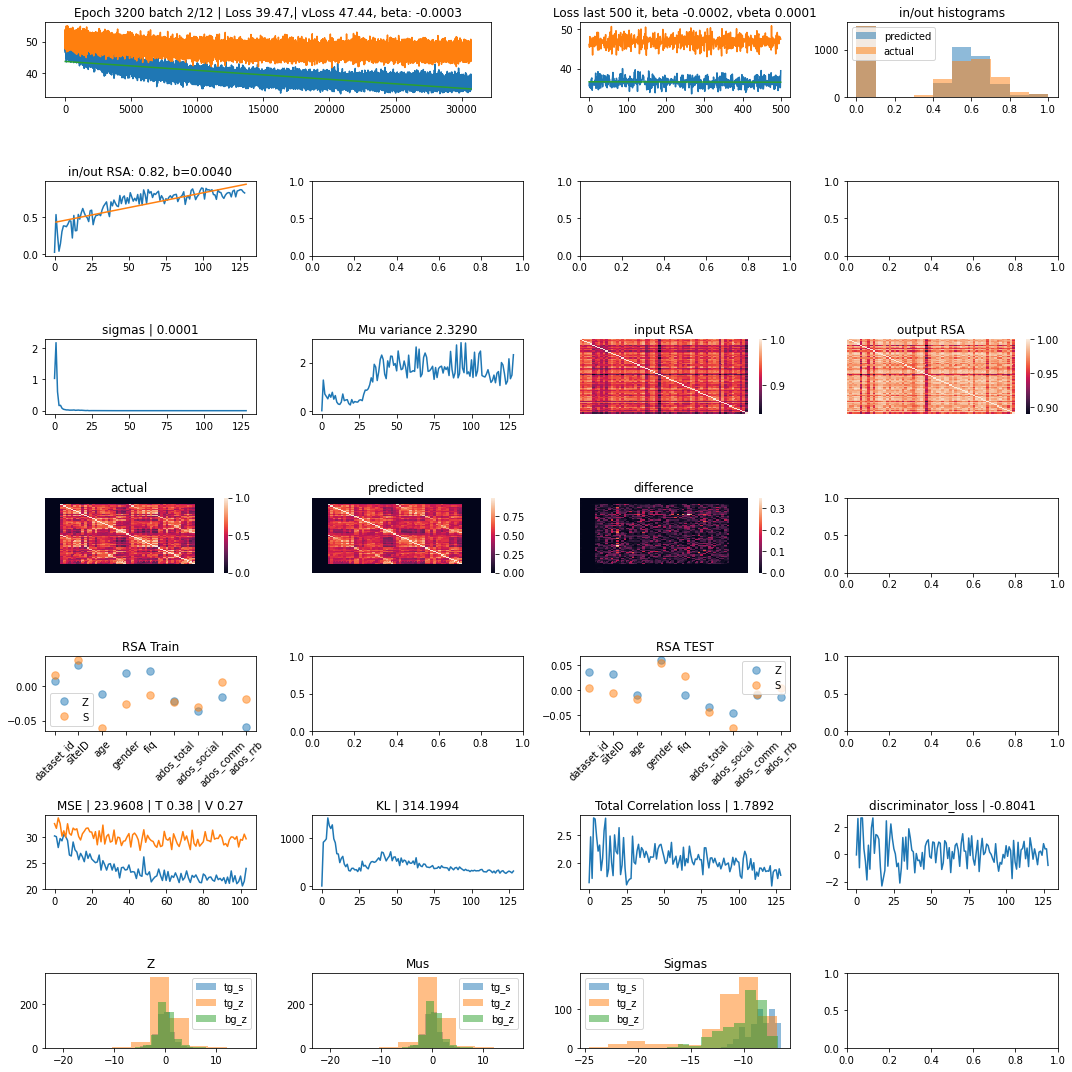

 64%|██████▍   | 3206/5001 [1:10:10<39:17,  1.31s/it]  

stopping


In [44]:
if train==True:
    for epoch in tqdm(range(5000+1)):
        
        if do_break==True:
            break
        
        for i in range(data_loader.n_batches):

            patient_batch,control_batch,batch_df = data_loader.get_batch() # Get a batch

            hist = cvae.train_on_batch([patient_batch[:,:,:,np.newaxis],control_batch[:,:,:,np.newaxis]]) # pass a batch

            assert not np.isnan(hist),'loss is NaN - you f**cked up'  # check nothing crashed
            loss.append(hist) # keep track of loss
            
            # Validation loss
            patient_batch_val,control_batch_val,_ = validation_loader.get_batch()
            val_loss.append(cvae.test_on_batch([patient_batch_val[:,:,:,np.newaxis],control_batch_val[:,:,:,np.newaxis]]))
            
            nstop = 5000
            if len(val_loss)>nstop: # Stop if val loss over the last 1000 batches is going up
                m_val,b_val = np.polyfit(np.arange(nstop),np.array(val_loss[-nstop::]),deg=1)
                
                if m_val > 0:
                    print('stopping')
                    do_break=True
           
            if all((i==0,np.mod(epoch,25)==0)):
                
                # VarExp
                varExp_train = getVarExp(cmats_train,patients)
                varExp_val = getVarExp(cmats_val,patients_val)
                
                cvae_dashboard() # plot training progress
                cvae.save_weights(os.path.join(save_dir,'cvae_weights')) # SAVE WEIGHTS
                np.save(os.path.join(save_dir,'cvae_loss.npy'),np.array(loss)) # Save loss     
            
            if do_break==True:
                break

In [45]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [46]:
def key_rsa(inMat,key,df,model_scale,return_models=False):
    vec = df[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='kendall') for i in range(10)])

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [47]:
def fit_rsa(rdm_data,rdm_model,measure='pearson',cov=None):
    from scipy.stats import kendalltau
    from pingouin import partial_corr
    
    if measure=='pearson':
        r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    elif measure=='kendall':
        r = kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif measure=='partial_kendall':
        arr = pd.DataFrame(np.array([get_triu(rdm_data),get_triu(rdm_model),get_triu(cov)]).transpose(),columns=['x','y','cv1'])
        r = partial_corr(data=arr, x='x', y='y', covar='cv1')['r'].values[0]
            
    return r

In [48]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True,lbls=['VAE','BG','SL']):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = lbls.copy()
    
    plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(len(xlbls))])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = lbls.copy()
        for i in range(1,c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = lbls.copy()

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [49]:
%%time

# Z_train = np.array([z_encoder.predict(pad2d(cmats_train[:,:,:,np.newaxis]))[2] for _ in range(10)])
# S_train = np.array([s_encoder.predict(pad2d(cmats_train[:,:,:,np.newaxis]))[2] for _ in range(10)])

# Z_val = np.array([z_encoder.predict(pad2d(cmats_val[:,:,:,np.newaxis]))[2] for _ in range(10)])
# S_val = np.array([s_encoder.predict(pad2d(cmats_val[:,:,:,np.newaxis]))[2] for _ in range(10)])

# Z_test = np.array([z_encoder.predict(pad2d(cmats_test[:,:,:,np.newaxis]))[2] for _ in range(10)])
#S_test = np.array([s_encoder.predict(pad2d(cmats_test[:,:,:,np.newaxis]))[2] for _ in range(10)])

# Test mode predictions https://stackoverflow.com/questions/47787011/how-to-disable-dropout-while-prediction-in-keras
Z_train = np.array([z_encoder(pad2d(cmats_train[:,:,:,np.newaxis]))[2] for _ in range(10)])
S_train = np.array([s_encoder(pad2d(cmats_train[:,:,:,np.newaxis]))[2] for _ in range(10)])

#Z_val = np.array([z_encoder(pad2d(cmats_val[:,:,:,np.newaxis]))[2] for _ in range(10)])
#S_val = np.array([s_encoder(pad2d(cmats_val[:,:,:,np.newaxis]))[2] for _ in range(10)])

Z_test = np.array([z_encoder(pad2d(cmats_test[:,:,:,np.newaxis]))[2] for _ in range(10)])
S_test = np.array([s_encoder(pad2d(cmats_test[:,:,:,np.newaxis]))[2] for _ in range(10)])


recon_train = np.array([flatten_cmat(np.array(depad(cvae_decoder(np.concatenate((Z_train,S_train),axis=2)[i,:,:])[:,:,:,0]))) for i in range(10)])
twin_train = np.array([flatten_cmat(np.array(depad(cvae_decoder(np.concatenate((Z_train,np.zeros(Z_train.shape)),axis=2)[i,:,:])[:,:,:,0]))) for i in range(10)])
dmat_train = recon_train-twin_train


# recon_val = np.array([flatten_cmat(np.array(depad(cvae_decoder(np.concatenate((Z_val,S_val),axis=2)[i,:,:])[:,:,:,0]))) for i in range(10)])
# twin_val = np.array([flatten_cmat(np.array(depad(cvae_decoder(np.concatenate((Z_val,np.zeros(Z_val.shape)),axis=2)[i,:,:])[:,:,:,0]))) for i in range(10)])
# dmat_val = recon_val-twin_val

recon_test = np.array([flatten_cmat(np.array(depad(cvae_decoder(np.concatenate((Z_test,S_test),axis=2)[i,:,:])[:,:,:,0]))) for i in range(10)])
twin_test = np.array([flatten_cmat(np.array(depad(cvae_decoder(np.concatenate((Z_test,np.zeros(Z_test.shape)),axis=2)[i,:,:])[:,:,:,0]))) for i in range(10)])
dmat_test = recon_test-twin_test

CPU times: user 55.6 s, sys: 4.07 s, total: 59.7 s
Wall time: 42.4 s


In [50]:
## TRAIN
v1 = {'label' : 'CMAT', 'data' : np.array([flatten_cmat(cmats_train[patients,:,:]) for i in range(10)]), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'Recon', 'data' : recon_train[:,patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'DMAT', 'data' : dmat_train[:,patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'BG', 'data' : Z_train[:,patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v5 = {'label' : 'SL', 'data' : S_train[:,patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat_train = [v1,v2,v3,v4,v5]


rsa_res_train = dict()
keys = ['dataset_id', 'siteID','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res_train.update({keys[i] : key_rsa(inMat_train,keys[i],df=df_train.iloc[patients],model_scale=data_scale[i])})

  0%|          | 0/10 [00:00<?, ?it/s]/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


In [51]:
# ## Val
# v1 = {'label' : 'CMAT', 'data' : np.array([flatten_cmat(cmats_val[patients_val,:,:]) for i in range(10)]), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
# v2 = {'label' : 'Recon', 'data' : recon_val[:,patients_val,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
# v3 = {'label' : 'DMAT', 'data' : dmat_val[:,patients_val,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
# v4 = {'label' : 'BG', 'data' : Z_val[:,patients_val,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
# v5 = {'label' : 'SL', 'data' : S_val[:,patients_val,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
# inMat_val = [v1,v2,v3,v4,v5]


# rsa_res_val = dict()
# keys = ['dataset_id', 'siteID','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
# data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

# for i in tqdm(range(len(keys))):
#     rsa_res_val.update({keys[i] : key_rsa(inMat_val,keys[i],df=df_val.iloc[patients_val],model_scale=data_scale[i])})


In [52]:
## Test
v1 = {'label' : 'CMAT', 'data' : np.array([flatten_cmat(cmats_test[patients_test,:,:]) for i in range(10)]), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'Recon', 'data' : recon_test[:,patients_test,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'DMAT', 'data' : dmat_test[:,patients_test,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'BG', 'data' : Z_test[:,patients_test,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v5 = {'label' : 'SL', 'data' : S_test[:,patients_test,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat_test = [v1,v2,v3,v4,v5]


rsa_res_test = dict()
keys = ['dataset_id', 'siteID','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res_test.update({keys[i] : key_rsa(inMat_test,keys[i],df=df_test.iloc[patients_test],model_scale=data_scale[i])})
    


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


<Figure size 864x2880 with 0 Axes>

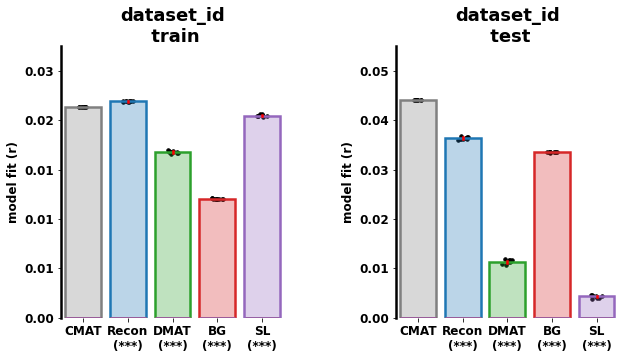

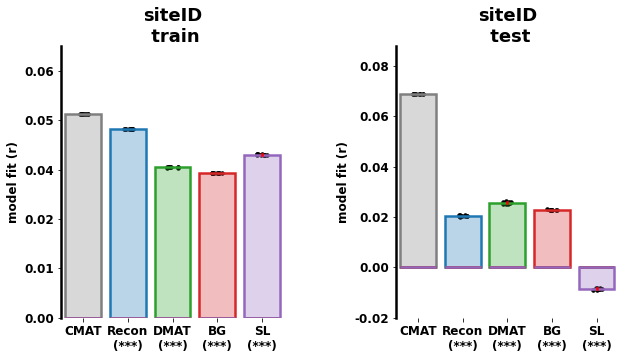

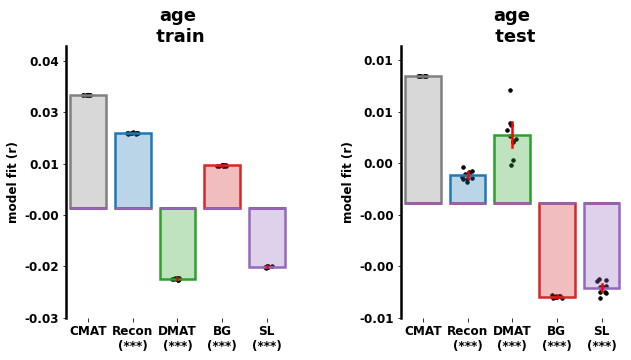

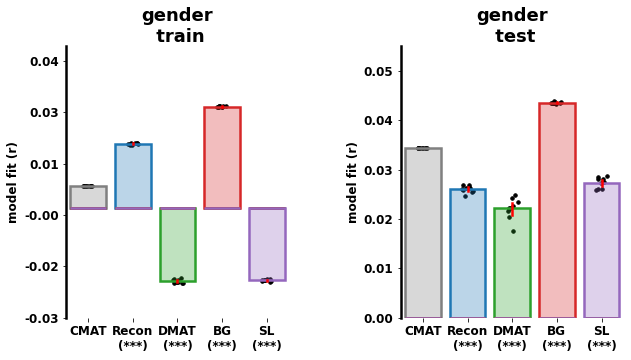

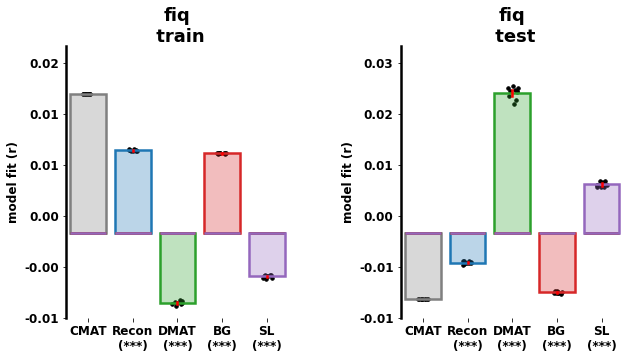

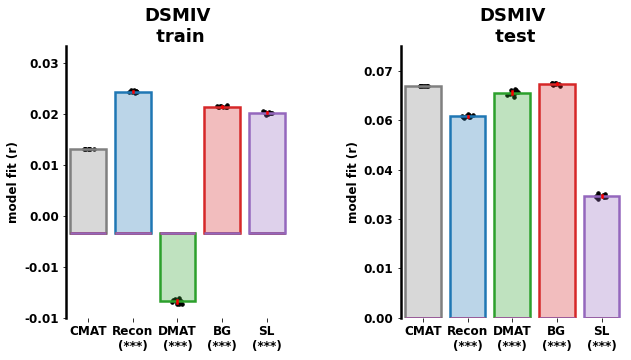

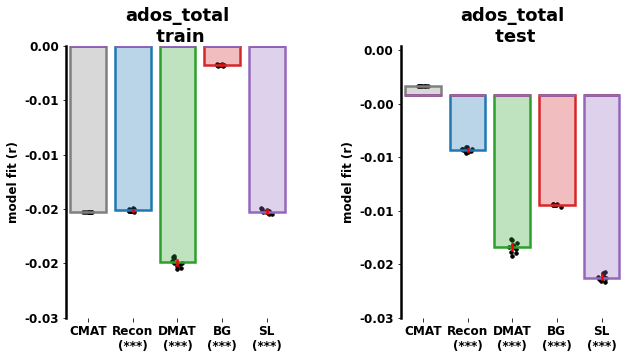

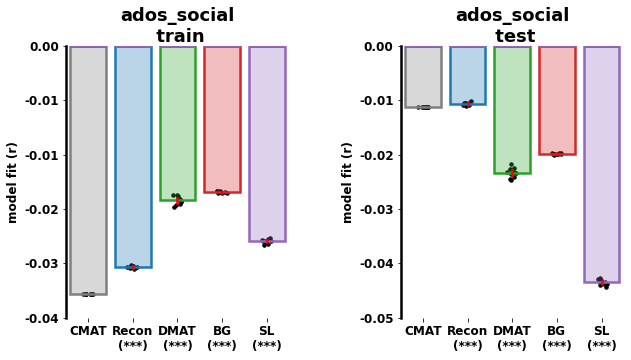

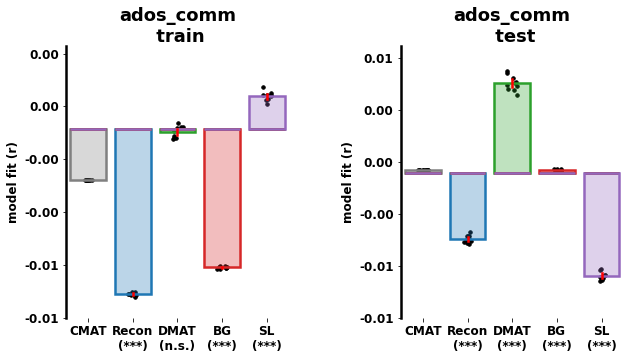

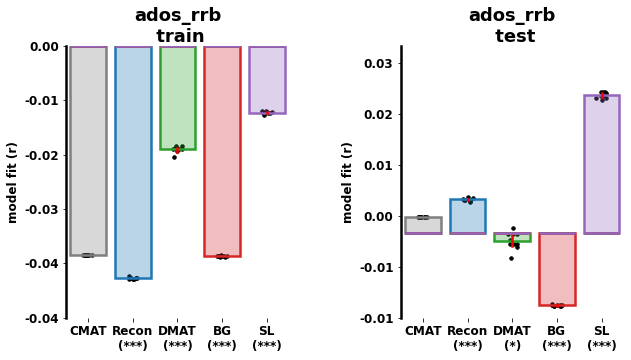

In [53]:
ncols = 3
nrows = len(keys)
plt.figure(figsize=np.array((ncols,nrows))*4)


for i,key in enumerate(keys):
    
    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1)
    rsa_res = rsa_res_train
    inMat = inMat_train
    plot_nice_bar(key,rsa_res,ax=ax,figsize=None,dpi=300,fontsize=12,fontsize_star=12,fontweight='bold',line_width=2.5,marker_size=12,title=keys[i]+'\n train',lbls=[inMat[j]['label'] for j in range(len(inMat))])

#     ax = plt.subplot(1,2,2)
#     rsa_res = rsa_res_val
#     inMat = inMat_val
#     plot_nice_bar(key,rsa_res,ax=ax,figsize=None,dpi=300,fontsize=12,fontsize_star=12,fontweight='bold',line_width=2.5,marker_size=12,title=keys[i]+'\n val',lbls=[inMat[j]['label'] for j in range(len(inMat))])

    ax = plt.subplot(1,2,2)
    rsa_res = rsa_res_test
    inMat = inMat_test
    plot_nice_bar(key,rsa_res,ax=ax,figsize=None,dpi=300,fontsize=12,fontsize_star=12,fontweight='bold',line_width=2.5,marker_size=12,title=keys[i]+'\n test',lbls=[inMat[j]['label'] for j in range(len(inMat))])
        
    plt.subplots_adjust(
        left=None,
        bottom=None,
        right=None,
        top=None,
        wspace=.5,
        hspace=.5)

In [54]:
import pickle
pickle.dump(rsa_res_train,open(os.path.join(save_dir,'rsa_res_train.pkl'),'wb'))

pickle.dump(rsa_res_test,open(os.path.join(save_dir,'rsa_res_test.pkl'),'wb'))

### Save latent representations

In [55]:
patients = df['diag'].values==1

In [56]:
cmats_padded = pad2d(cmats[:,:,:,np.newaxis])

In [57]:
Z_mu,Z_sigma,Z = z_encoder.predict(cmats_padded)
S_mu,S_sigma,S = s_encoder.predict(cmats_padded)

In [58]:
Z_sample100 = np.array([z_encoder.predict(cmats_padded)[2] for _ in tqdm(range(100))])
S_sample100 = np.array([s_encoder.predict(cmats_padded)[2] for _ in tqdm(range(100))])

100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


In [59]:
recon_td_mu = cvae_predict(Z_mu[~patients,:],S_mu[~patients,:],asd=False)
recon_asd_mu = cvae_predict(Z_mu[patients,:],S_mu[patients,:],asd=True)
recon_twin_mu = cvae_predict(Z_mu[patients,:],S_mu[patients,:],asd=False)

In [60]:
recon_td_mu = depad(recon_td_mu)
recon_asd_mu = depad(recon_asd_mu)
recon_twin_mu = depad(recon_twin_mu)

In [ ]:
recon_td_samples = np.array([cvae_predict(Z_sample100[i,~patients,:],S_sample100[i,~patients,:],asd=False) for i in tqdm(range(Z_sample100.shape[0]))])
recon_asd_samples = np.array([cvae_predict(Z_sample100[i,patients,:],S_sample100[i,patients,:],asd=True) for i in tqdm(range(Z_sample100.shape[0]))])
recon_twin_samples = np.array([cvae_predict(Z_sample100[i,patients,:],S_sample100[i,patients,:],asd=False) for i in tqdm(range(Z_sample100.shape[0]))])

100%|██████████| 100/100 [00:00<00:00, 208.69it/s]


In [ ]:
recon_td_samples = np.array([depad(recon_td_samples[i,:,:,:]) for i in range(recon_td_samples.shape[0])])
recon_asd_samples = np.array([depad(recon_asd_samples[i,:,:,:]) for i in range(recon_asd_samples.shape[0])])
recon_twin_samples = np.array([depad(recon_twin_samples[i,:,:,:]) for i in range(recon_twin_samples.shape[0])])

In [ ]:
results = dict()
results['Z_mu'] = Z_mu
results['Z_sigma'] = Z_sigma
results['Z'] = Z
results['S_mu'] = S_mu
results['S_sigma'] = S_sigma
results['S'] = S
results['Z_sample100'] = Z_sample100
results['S_sample100'] = S_sample100
results['recon_td_mu'] = recon_td_mu
results['recon_asd_mu'] = recon_asd_mu
results['recon_twin_mu'] = recon_twin_mu
results['recon_td_samples'] = recon_td_samples
results['recon_asd_samples'] = recon_asd_samples
results['recon_twin_samples'] = recon_twin_samples

In [ ]:
# Save the files
[np.savez_compressed(os.path.join(save_dir,key+'.npz'),data=results[key]) for key in list(results.keys())];

In [ ]:
# Dump as a pickle just in case
import pickle
with open((os.path.join(save_dir,'results.pickle')),'wb') as f:
    pickle.dump(results, f)

In [ ]:
%%time
# Save as a big numpy arr
np.savez_compressed(file=os.path.join(save_dir,'results.npz'),
                    Z_mu=Z_mu,
                    Z_sigma=Z_sigma,
                    Z=Z,
                    S_mu=S_mu,
                    S_sigma=S_sigma,
                    S=S,
                    Z_sample100=Z_sample100,
                    S_sample100=S_sample100,
                    recon_td_mu=recon_td_mu,
                    recon_asd_mu=recon_asd_mu,
                    recon_twin_mu=recon_twin_mu,
                    recon_td_samples=recon_td_samples,
                    recon_asd_samples=recon_asd_samples,
                    recon_twin_samples=recon_twin_samples)

In [ ]:
hypers = {
'latent_dim1' : [latent_dim1],
'latent_dim2' : [latent_dim2],
'beta' :  [beta],
'gamma' :  [gamma],
'batch_size' : [batch_size],
'kernel_size' : [kernel_size],
'filters' : [filters],
'intermediate_dim' : [intermediate_dim],
'nlayers' : [nlayers],
'strides' : [strides],
'learning_rate' : [learning_rate],
'opt' : str(opt),
'loss' : loss[-1],
'sigmas' : sigmas[-1],
'mus' : mus[-1],
'c_sim' : c_sim[-1],
'loss_mse' : loss_mse[-1],
'loss_kl' : loss_kl[-1],
'loss_dc' : loss_dc[-1],
'loss_tc' : loss_tc[-1],
'nepochs' : epoch}

hypers_csv = pd.DataFrame(hypers,index=[0])
hypers_csv.to_csv(os.path.join(save_dir,'hyperparams.csv'))

In [ ]:
cvae.summary(line_length=150)

In [ ]:
# import shutil
# shutil.copyfile(src=nb_name,dst=os.path.join(save_dir,nb_name))